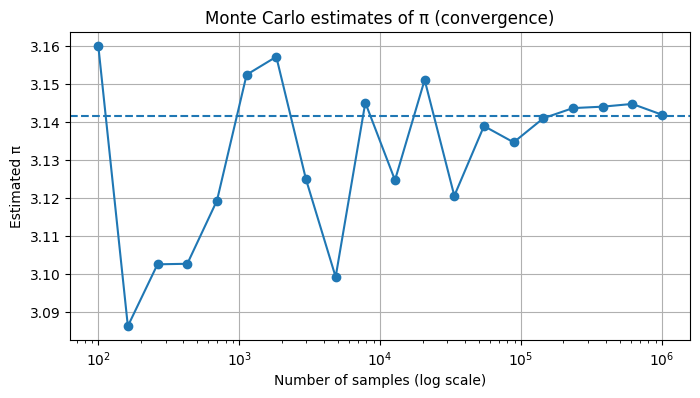

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def monte_carlo_pi(n):
    x = np.random.rand(n)
    y = np.random.rand(n)
    inside = (x**2 + y**2) <= 1.0
    return inside.sum() / n * 4.0


sample_sizes = np.logspace(2, 6, num=20, dtype=int)  # from 1e2 to 1e6
pi_estimates = []
for n in sample_sizes:
    pi_estimates.append(monte_carlo_pi(n))


plt.figure(figsize=(8,4))
plt.plot(sample_sizes, pi_estimates, marker='o')
plt.xscale('log')
plt.axhline(np.pi, linestyle='--')
plt.title("Monte Carlo estimates of π (convergence)")
plt.xlabel("Number of samples (log scale)")
plt.ylabel("Estimated π")
plt.grid(True)
plt.show()

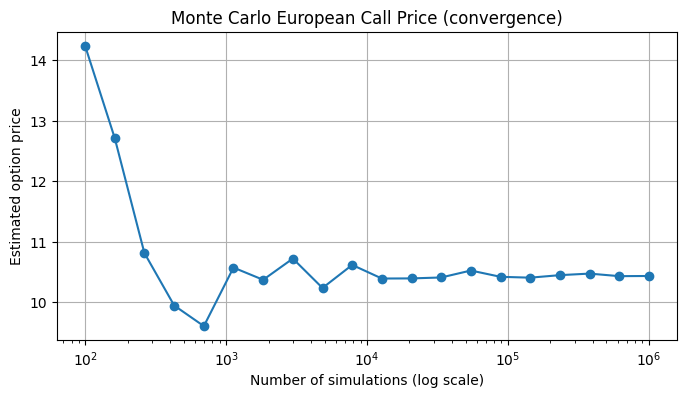

Sample of results (first 5 rows):
   n_sims   mc_price  std_error
0     100  14.234520   1.768780
1     162  12.715270   1.407663
2     263  10.816352   0.928332
3     428   9.948494   0.656488
4     695   9.607847   0.537550


In [2]:
S0 = 100.0   # initial stock price
K = 100.0    # strike price
T = 1.0      # time to maturity (1 year)
r = 0.05     # risk-free rate
sigma = 0.2  # volatility

def monte_carlo_european_call(S0, K, T, r, sigma, n_sims):
    # simulate end-of-period stock price using geometric Brownian motion
    Z = np.random.randn(n_sims)
    ST = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)
    payoffs = np.maximum(ST - K, 0.0)
    discounted = np.exp(-r*T) * payoffs
    price = discounted.mean()
    std_error = discounted.std(ddof=1) / np.sqrt(n_sims)
    return price, std_error

# Run simulations for multiple sizes
option_results = []
for n in sample_sizes:
    price, se = monte_carlo_european_call(S0, K, T, r, sigma, n)
    option_results.append((n, price, se))

df_option = pd.DataFrame(option_results, columns=['n_sims','mc_price','std_error'])

# Plot Monte Carlo price convergence
plt.figure(figsize=(8,4))
plt.plot(df_option['n_sims'], df_option['mc_price'], marker='o')
plt.xscale('log')
plt.title("Monte Carlo European Call Price (convergence)")
plt.xlabel("Number of simulations (log scale)")
plt.ylabel("Estimated option price")
plt.grid(True)
plt.show()

# Print a short summary
print("Sample of results (first 5 rows):")
print(df_option.head())

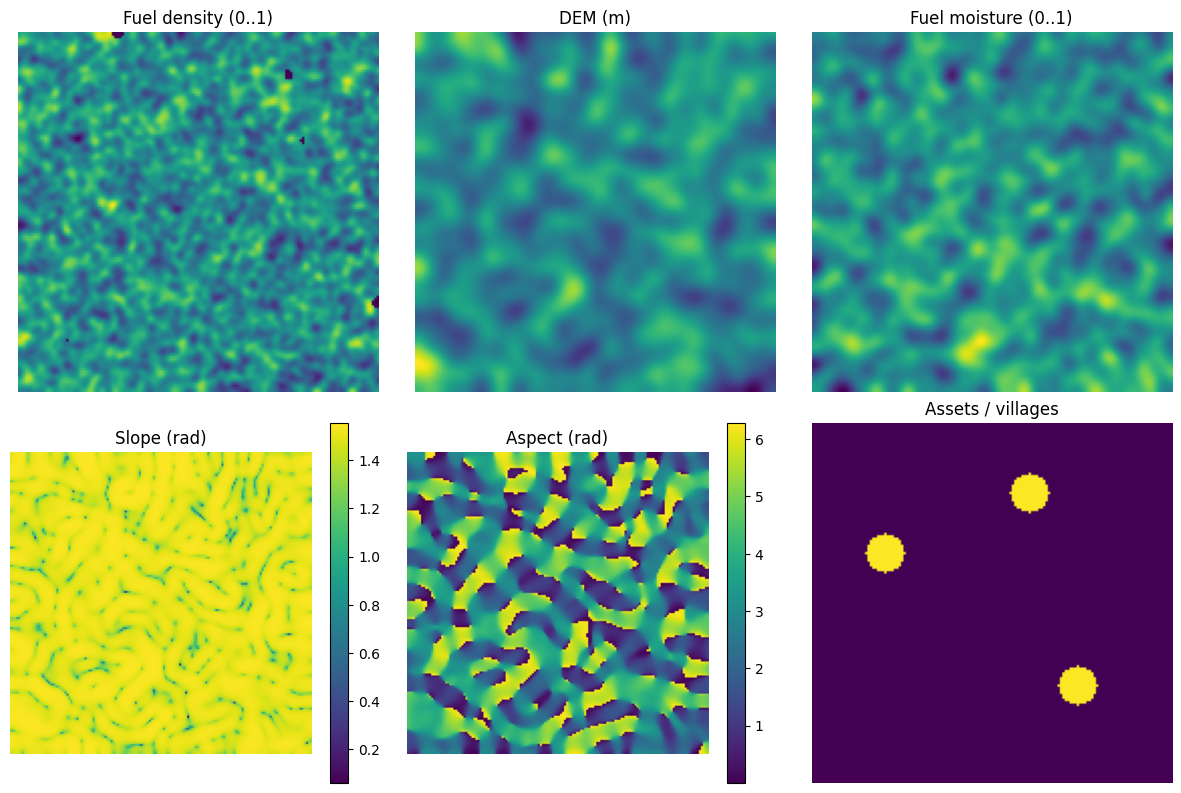

In [3]:
# Synthetic landscape generator: fuel map, DEM, slope/aspect, moisture
import numpy as np
import matplotlib.pyplot as plt

# Try to import gaussian_filter; fallback to simple numpy blur if scipy unavailable
try:
    from scipy.ndimage import gaussian_filter
    use_scipy = True
except Exception:
    use_scipy = False

def smooth_noise(noise, sigma):
    if use_scipy:
        return gaussian_filter(noise, sigma=sigma, mode='reflect')
    else:
        # simple separable box blur as fallback
        from numpy import pad, convolve
        k = max(1, int(round(sigma)))
        kernel = np.ones(k) / k
        tmp = np.apply_along_axis(lambda v: np.convolve(v, kernel, mode='same'), axis=0, arr=noise)
        out = np.apply_along_axis(lambda v: np.convolve(v, kernel, mode='same'), axis=1, arr=tmp)
        return out

def fractal_noise(shape, octaves=4, persistence=0.5, base_sigma=1.5, rng=None):
    """
    Create a multi-octave smoothed noise field (Perlin-like) using gaussian smoothing of white noise.
    - shape: (H,W)
    - octaves: number of scales
    - persistence: amplitude decay per octave
    - base_sigma: smoothing for first octave
    """
    if rng is None: rng = np.random.default_rng()
    H, W = shape
    out = np.zeros((H,W), dtype=float)
    amplitude = 1.0
    total_amp = 0.0
    for o in range(octaves):
        noise = rng.standard_normal((H,W))
        sigma = base_sigma * (2**o)  # larger sigma = larger-scale features
        smooth = smooth_noise(noise, sigma)
        out += amplitude * smooth
        total_amp += amplitude
        amplitude *= persistence
    out /= total_amp
    # normalize to 0..1
    out = (out - out.min()) / (out.max() - out.min() + 1e-12)
    return out

def compute_slope_aspect(dem, cell_size=1.0):
    # dem: 2D elevation in meters
    # slope: radians, aspect: radians (0 = +x/east, pi/2 = +y/north)
    dy, dx = np.gradient(dem, cell_size, cell_size)
    slope = np.arctan(np.sqrt(dx*dx + dy*dy))
    aspect = np.arctan2(dy, dx)  # angle of steepest ascent
    # convert aspect to 0..2pi
    aspect = (aspect + 2*np.pi) % (2*np.pi)
    return slope, aspect

# Parameters
H, W = 150, 150
seed = 42
rng = np.random.default_rng(seed)

# 1) Fuel density field (0..1)
fuel = fractal_noise((H,W), octaves=4, persistence=0.55, base_sigma=1.5, rng=rng)

# Optionally make some non-fuel patches (lakes / roads)
mask = fractal_noise((H,W), octaves=3, persistence=0.6, base_sigma=2.0, rng=rng)
water = mask > 0.85
fuel[water] = 0.0

# 2) DEM (elevation) - different parameters for larger-scale hills
dem = fractal_noise((H,W), octaves=5, persistence=0.6, base_sigma=4.0, rng=rng)
dem = dem * 600.0  # scale to meters (0-600m)

# 3) Fuel moisture (0..1) - higher moisture lowers ignition probability
moisture = fractal_noise((H,W), octaves=3, persistence=0.5, base_sigma=3.0, rng=rng)
# correlate moisture with elevation (higher elevation -> maybe more moist)
moisture = 0.6*moisture + 0.4*(1.0 - (dem - dem.min())/(dem.max()-dem.min()))
moisture = np.clip(moisture, 0.0, 1.0)

# 4) Assets map / ignition hotspots (optional)
assets = np.zeros((H,W), dtype=int)
# put a few circular villages
vcenters = [(40, 110), (95, 30), (120, 90)]
for (r,c) in vcenters:
    rr, cc = np.ogrid[:H, :W]
    maskv = (rr - r)**2 + (cc - c)**2 <= 8**2
    assets[maskv] = 1

# 5) Derived fields: slope & aspect
slope, aspect = compute_slope_aspect(dem, cell_size=1.0)

# Visualize
fig, axs = plt.subplots(2,3, figsize=(12,8))
axs = axs.ravel()
axs[0].imshow(fuel, origin='lower'); axs[0].set_title('Fuel density (0..1)')
axs[1].imshow(dem, origin='lower'); axs[1].set_title('DEM (m)')
axs[2].imshow(moisture, origin='lower'); axs[2].set_title('Fuel moisture (0..1)')
im = axs[3].imshow(slope, origin='lower'); axs[3].set_title('Slope (rad)'); fig.colorbar(im, ax=axs[3])
im2 = axs[4].imshow(aspect, origin='lower'); axs[4].set_title('Aspect (rad)'); fig.colorbar(im2, ax=axs[4])
axs[5].imshow(assets, origin='lower'); axs[5].set_title('Assets / villages')
for a in axs: a.axis('off')
plt.tight_layout()
plt.show()


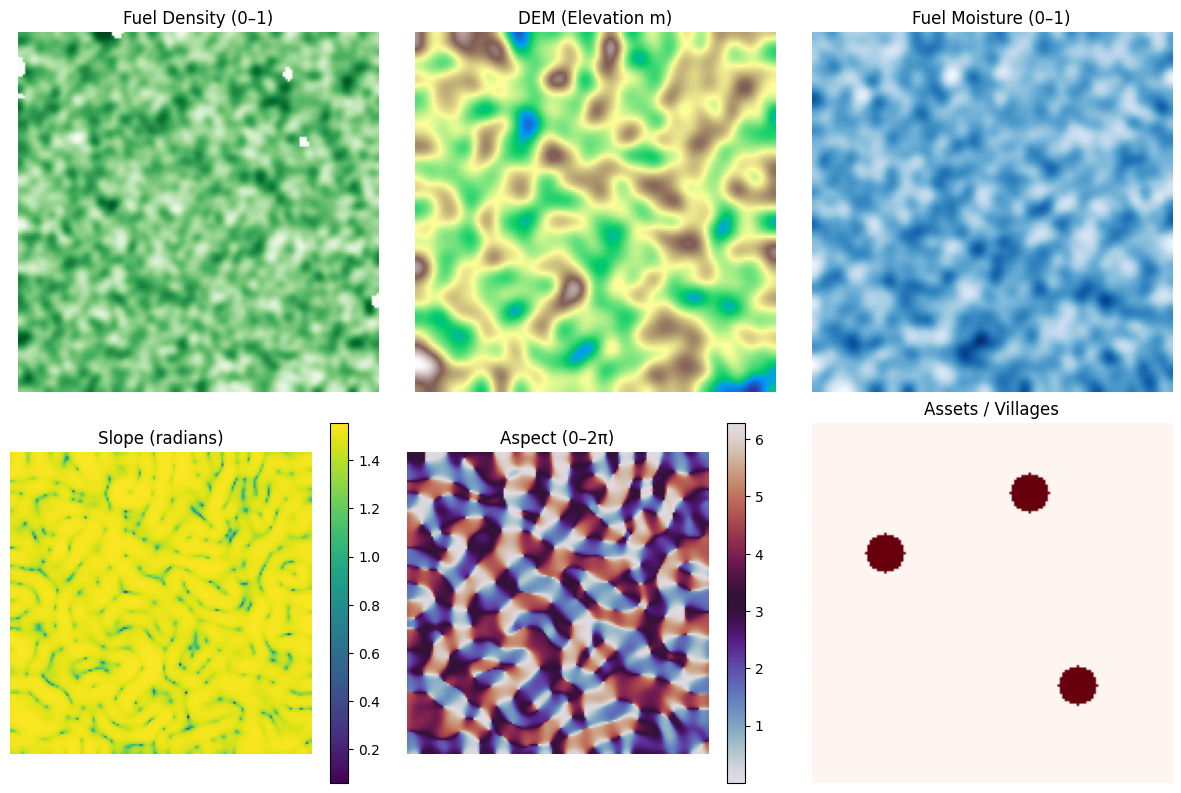

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


# ----------------------------------------------------------
#  Smooth multi-octave noise (Perlin-like synthetic landscape)
# ----------------------------------------------------------
def fractal_noise(shape, octaves=4, persistence=0.5, base_sigma=2.0, rng=None):
    """
    Creates multi-scale noise using gaussian smoothing.
    Similar to Perlin noise but simpler — perfect for fire simulations.
    """
    if rng is None:
        rng = np.random.default_rng()
        
    H, W = shape
    out = np.zeros((H, W), dtype=float)
    amplitude = 1.0
    total_amp = 0.0
    
    for o in range(octaves):
        noise = rng.standard_normal((H, W))
        sigma = base_sigma * (2 ** o)   # larger sigma = larger features
        
        smooth = gaussian_filter(noise, sigma=sigma, mode="reflect")
        
        out += amplitude * smooth
        total_amp += amplitude
        amplitude *= persistence  # reduce influence each octave
    
    out /= total_amp
    out = (out - out.min()) / (out.max() - out.min() + 1e-12)
    return out


# ----------------------------------------------------------
#  Compute Slope + Aspect from DEM
# ----------------------------------------------------------
def compute_slope_aspect(dem, cell_size=1.0):
    """
    dem: elevation map (meters)
    slope: radians
    aspect: radians, 0 = east, pi/2 = north
    """
    dy, dx = np.gradient(dem, cell_size, cell_size)
    
    slope = np.arctan(np.sqrt(dx*dx + dy*dy))      # slope angle
    aspect = np.arctan2(dy, dx)                   # steepest ascent direction
    aspect = (aspect + 2*np.pi) % (2*np.pi)       # wrap to 0..2π
    
    return slope, aspect


# ----------------------------------------------------------
#  PARAMETERS
# ----------------------------------------------------------
H, W = 150, 150
rng = np.random.default_rng(42)


# ----------------------------------------------------------
#  1) Fuel density map (0..1): MORE CLUSTERED REALISM
# ----------------------------------------------------------
fuel = fractal_noise((H, W), octaves=4, persistence=0.55, base_sigma=1.8, rng=rng)

# Optional: remove fuel in lake/road regions
lake_mask = fractal_noise((H, W), octaves=3, persistence=0.6, base_sigma=3.0, rng=rng)
lake = lake_mask > 0.85
fuel[lake] = 0.0


# ----------------------------------------------------------
#  2) DEM (elevation) — smooth hills + valleys
# ----------------------------------------------------------
dem = fractal_noise((H, W), octaves=5, persistence=0.6, base_sigma=4.0, rng=rng)
dem = dem * 600.0   # scale to meters (0–600 m)


# ----------------------------------------------------------
#  3) Fuel moisture (0..1)
#     Higher elevation = slightly more moisture
# ----------------------------------------------------------
moisture = fractal_noise((H, W), octaves=3, persistence=0.5, base_sigma=2.5, rng=rng)
elev_norm = (dem - dem.min()) / (dem.max() - dem.min())
moisture = 0.6 * moisture + 0.4 * (1.0 - elev_norm)
moisture = np.clip(moisture, 0.0, 1.0)


# ----------------------------------------------------------
#  4) Asset map (villages / buildings)
# ----------------------------------------------------------
assets = np.zeros((H, W), dtype=int)
vcenters = [(40, 110), (95, 30), (120, 90)]
for (r, c) in vcenters:
    rr, cc = np.ogrid[:H, :W]
    mask = (rr - r)**2 + (cc - c)**2 <= 8**2
    assets[mask] = 1


# ----------------------------------------------------------
#  5) Compute slope + aspect
# ----------------------------------------------------------
slope, aspect = compute_slope_aspect(dem)


# ----------------------------------------------------------
#  Visualize Everything
# ----------------------------------------------------------
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.ravel()

axs[0].imshow(fuel, origin="lower", cmap="Greens")
axs[0].set_title("Fuel Density (0–1)")

axs[1].imshow(dem, origin="lower", cmap="terrain")
axs[1].set_title("DEM (Elevation m)")

axs[2].imshow(moisture, origin="lower", cmap="Blues")
axs[2].set_title("Fuel Moisture (0–1)")

im3 = axs[3].imshow(slope, origin="lower")
axs[3].set_title("Slope (radians)")
fig.colorbar(im3, ax=axs[3])

im4 = axs[4].imshow(aspect, origin="lower", cmap="twilight")
axs[4].set_title("Aspect (0–2π)")
fig.colorbar(im4, ax=axs[4])

axs[5].imshow(assets, origin="lower", cmap="Reds")
axs[5].set_title("Assets / Villages")

for a in axs:
    a.axis("off")

plt.tight_layout()
plt.show()
